 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [88]:
#Lyna Hocine, 21211454
#Mariana Duarte Ferreira, 21501059

# Outlook

In this notebook, we study basic linear and non-linear regression algorithms.
Regression is another name for function approximation, it consists in fitting a function to a set of points, as shown below.

The notebook is meant to study elements presented in lessons available in video here 
https://www.youtube.com/playlist?list=PLe5mY-Da-ksURGcelU-egwtWZXxVgZ76a

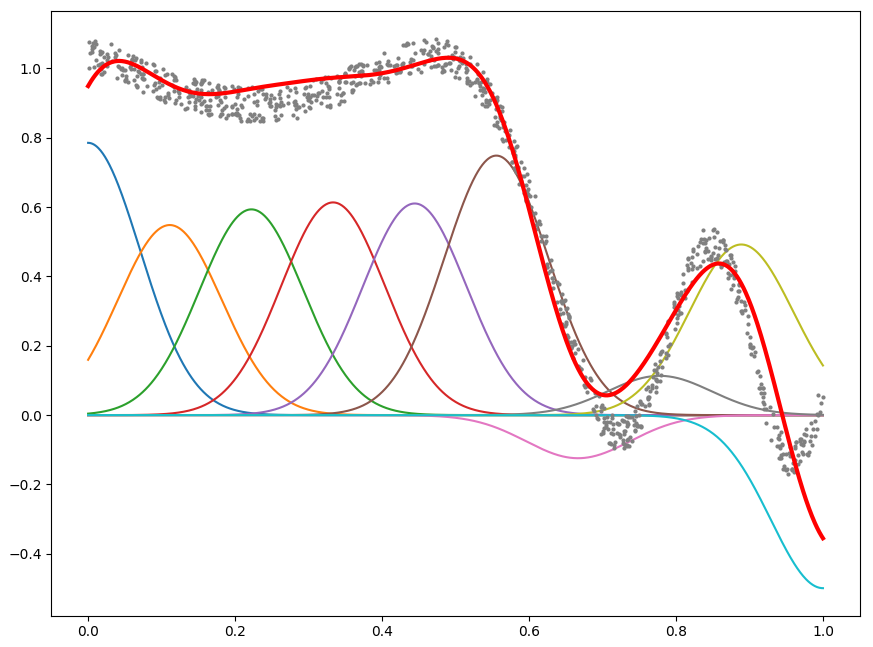


The notebook contains coding parts, where you have to code the main regression algorithms and check they work with a visualization,
and study parts, where you investigate their properties when changing some parameters or where you perform comparisons between methods. 
The study part may involve further coding to generate appropriate diagrams.

There are more studies than doable in a short time.
Do what you can among the studies. 
Doing one study accurately is better than being inaccurate on all studies.


# Installation

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

%pip install -q git+https://github.com/osigaud/regressionLabs

from regression_labs.batch import Batch
from regression_labs.latent_function import LinearLatentFunction, NonLinearLatentFunction, NonLinearLatentXDFunction
from regression_labs.gaussians import Gaussians

Note: you may need to restart the kernel to use updated packages.


# Introduction

The objective of regression or function approximation is to create a model from observed data. 
The model has a fixed structure with parameters (like the coefficients of a polynomial for instance), 
and regression consists in adjusting these parameters to fit the data. 
In machine learning, it is a very important technique since having a good model enables better predictions and performance.

With mathematical notations, given some datapoints $\{ ({\bf x}, {\bf y}) \}$, 
the goal is to adjust a model ${\bf y} = f({\bf x})$ so that the *learned* function $f$ accounts for these datapoints 
and generalize well to other unseen points $\{ ({\bf x}, {\bf y}) \}$.

The simplest case is linear regression, which assumes a relation of type ${\bf y} = {\bf A}{\bf x} + {\bf b}$ 
between the data ${\bf x}$ and ${\bf y}$.

Several methods exist to adjust the parameters ${\bf A}$ and ${\bf b}$, 
the most well-known being the least squares method (or least norm in the multivariate case).

In this lab, we assume that ${\bf y}$  is of dimension 1 (and write $y$ instead of ${\bf y}$  in what follows). 
This is a very common assumption.

Furthermore, in the code ${\bf x}$ is also of dimension 1, this is more restrictive 
as regression is often used from multidimensional input data.

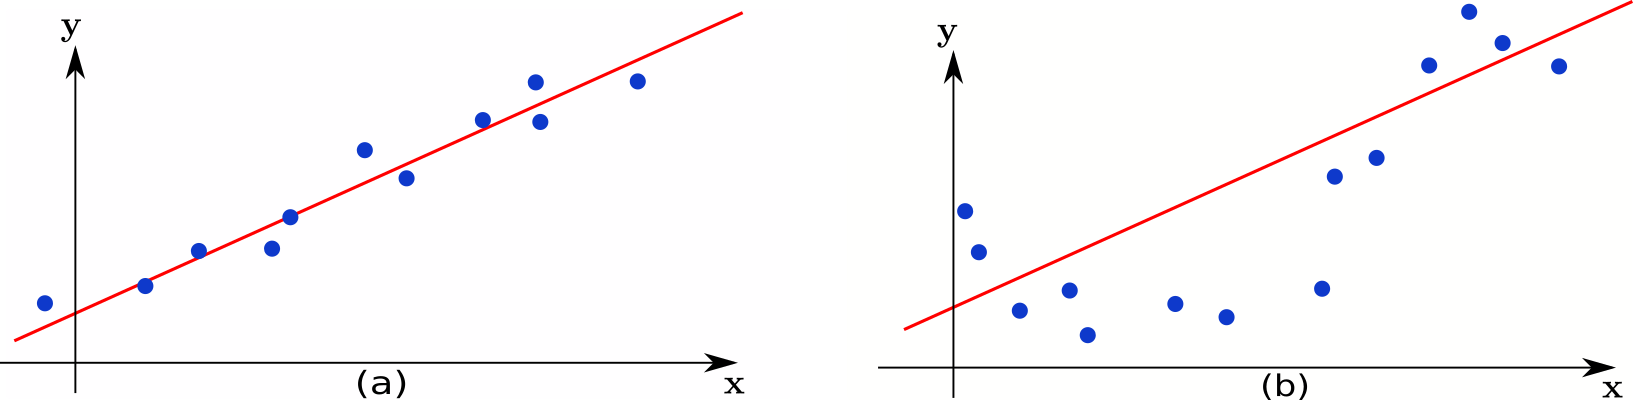


Often, linear models are not enough. For instance, see figures (a) and (b) above, 
on the left a linear regression is OK, but on the right it is not. 
In the case of (b), we must rely on nonlinear models. 
Here, we focus on the case where $f$ can be written as a sum of $k$ functions parametrized by vectors ${\boldsymbol{\theta}}_i$:

$$ f({\bf x})  = \sum_{i=1}^k f_{\boldsymbol{\theta}_i}({\bf x}).$$

In particular, we use Gaussian functions.

## Weighted sums of Gaussian functions

Gaussian functions $\phi_i({\bf x}) = \exp(-\frac{({\bf x}-{\bf c_i})^2}{\sigma_i^2})$ are almost equal to zero 
everywhere except in a neighborhood of ${\bf c_i}$, which represents the "center"' of the Gaussian (see the figure below). 
The value of $\sigma_i$ determines how large this neighborhood is.

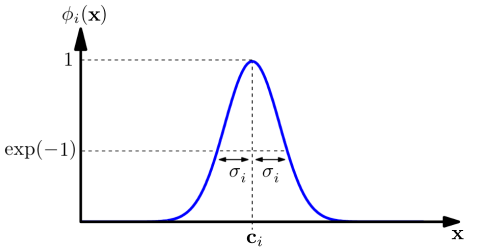

Then weighted Gaussian functions $f_{\boldsymbol{\theta}_i}$ can be written:

$$ f_{\boldsymbol{\theta}_i} = {\bf \theta}_i \phi_i({\bf x}) = {\bf \theta}_i \exp\left(-\frac{({\bf x}-{\bf c_i})^2}{\sigma_i^2}\right). $$

In RBFNs, the centers of the Gaussian functions are fixed in advance, and evenly distributed in the input space. 
Besides, all the $\sigma_i$'s are usually set to the same value.
Thus weighted Gaussian functions $f_{\boldsymbol{\theta}_i}$ have a unique scalar parameter 
which is their vector of weights $\boldsymbol{\theta}_i$.

# Provided code and documentation

The numpy reference guide is here: http://docs.scipy.org/doc/numpy/reference/

We provide a few useful classes and the infrastructure to perform these labs.

## Data generation

Two functions to generate points corresponding to a noisy linear and a noisy nonlinear model are provided in 
the ```LatentFunction``` class in the 
[latent_function.py](https://github.com/osigaud/regressionLabs/blob/main/regression_labs/latent_function.py) file.

## Batch of data

The [batch.py](https://github.com/osigaud/regressionLabs/blob/main/regression_labs/batch.py) file contains 
the ```Batch``` class. This class is used to collect a batch of linear or non-linear data, either in a single batch or incrementally.

## Vectors of Gaussian functions

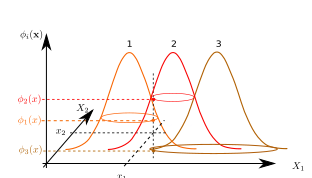

A ```Gaussians``` class is provided in [gaussians.py](https://github.com/osigaud/regressionLabs/blob/main/regression_labs/gaussians.py) 
to represent a vector of Gaussian feature functions $\phi({\bf x})$ of an input vector ${\bf x}$, 
as used in RBFNs and Locally Weighted Regression (LWR) (see below). 
The number $E$ of elements of $\phi({\bf x})$ (i.e. the number $E$ of Gaussian functions) is defined by the ```nb_features``` attribute. 

Given some input vector ${\bf x}$, the function ```phi_output(x)``` returns 
the vector of the output of (non-weighted) Gaussian functions applied to ${\bf x}$, thus a vector of size $E$.
In the particular case where $x$ is a scalar, it is transformed into a one element vector to keep consistent with the N-dimensional case.

Note that the input of the (multivariate) Gaussian functions is of the same dimension as ${\bf x}$, 
but their output is one-dimensional (see the figure above).

## Function approximators

We consider three families of approximation models: linear models , radial basis function networks and locally weigthed regression models. 
In all these models, the theta attribute represents the vector of parameters to be optimized. 
The ```f(self, x)``` function represents the function approximator output for a given input ```x```, to be optimized. 
The parameters used by $f$ are the elements of the ```theta``` vector.

For instance, for RBFNs, we consider a vector of $E$ Gaussian functions 
$\phi({\bf x}) = (\phi_1({\bf x}) \ \phi_2({\bf x}) \cdots \phi_E({\bf x}))^\intercal$, 
a vector of weights $\boldsymbol{\theta} = (\boldsymbol{\theta}_1 \ \boldsymbol{\theta}_2 \cdots \boldsymbol{\theta}_E)^\intercal$, 
and a vector of weighted Gaussian functions $f({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$.

These function approximation models come with various ```train_...(self, ...)``` functions that you must fill.

# Visualization

For all the regression methods described below, as illustrated in the figure at the top of this notebook, 
after executing it, the observed data are shown by points, and the red curve is the *learned* function $f$ 
corresponding to the parameters $\boldsymbol{\theta}$ that have been incrementally adjusted. 
When this applies, the other curves correspond to the $f_{\boldsymbol{\theta}_i}({\bf x})$ functions, 
they show the decomposition of $f$, which is the sum of all these functions. 
All visualization functions are in the ```plot()``` function of each approximator.

# Notations and code helpers

We consider either a batch regression approach, an iterative one or an incremental one. In the batch and iterative approaches, we consider a batch of data consisting of $N$ $\{ ({\bf x}_i, y_i) \}_{1 \leq i \leq N}$ pairs.
In the incremental one, we get an additional pair of data $({\bf x}^{(t)}, y^{(t)})$ at each time step $t$.

In the general case, an input datapoint ${\bf x}$ is of dimension $d$, and we have ${\bf x} = (x_1 \ x_2 \cdots x_d)^\intercal$.
Under algebraic form, the batch of data is rewritten $({\bf X}, {\bf y})$ where ${\bf X}$ is a $N \times d$ matrix and ${\bf y}$ is a $N$ dimensional vector.

## Issues with ```transpose()``` in numpy

In regression algorithms, we often use the transpose operator.
But in numpy, transposing a standard one-dimensional vector does not work as expected: the result of the tranpose operator is the same vector, which is quite unfortunate.

Below we define two functions to fix this issue.

In [2]:
import numpy as np

def horiz_to_verti(vec):
  return vec.reshape(-1, 1)


def verti_to_horiz(vec):
  return vec.reshape(-1)

And here is a small example about how to use it.

In [18]:
vec = np.zeros((3,2))
print(vec)
v2 = vec.transpose()
print ("incorrect transpose:", v2)
v3 = horiz_to_verti(vec)
print ("correct transpose:", v3)
v4 = verti_to_horiz(v3)

print ("transpose of the transpose:", v4)

[[0. 0.]
 [0. 0.]
 [0. 0.]]
incorrect transpose: [[0. 0. 0.]
 [0. 0. 0.]]
correct transpose: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
transpose of the transpose: [0. 0. 0. 0. 0. 0.]


## Augmenting the design matrix with one dimension

To solve a linear least square problem, we want to use a model of the form $f_\boldsymbol{\theta}({\bf X}) = \boldsymbol{\theta}^\intercal{\bf X} + {\bf b}$.
To deal more elegantly with the intercept ${\bf b}$, we extend the vectors ${\bf x}$ with an additional dimension
using $\bar{\bf x}_i = (x_{i,1} \ x_{i,2} \cdots x_{i,d} \ 1)^\intercal$, and we redefine the augmented design matrix as

$$\bar{\bf X}=\left(
\begin{array}{ccccc}
 x_{1,1}&x_{1,2}&\cdots &x_{1,d} &1\\
 x_{2,1}&x_{2,2}&\cdots &x_{2,d} &1\\
 \vdots  &\vdots  &\ddots &\vdots   &\vdots\\
 x_{N,1}&x_{N,2}&\cdots &x_{N,d} &1\\
\end{array}
\right).
$$

This way, our model can be rewritten $f_\boldsymbol{\theta}({\bf X}) = \boldsymbol{\theta'}^\intercal{\bar{\bf X}}$.

From the list of vectors *x_data* provided by the sample generator, $\bar{\bf X}$ can be obtained by first transforming *x_data* into a *numpy array* and transposing using

```x_data = numpy.array(x_data).transpose()```,

and then adding the ones with:

```barX = np.hstack((x_data, numpy.ones((x_data.shape[0], 1))))```

Let us define the ```bar_design()``` function

In [4]:
def bar_design(x):
  return np.hstack((x, np.ones((x.shape[0], 1))))

And check that it works.

In [5]:
lf = LinearLatentFunction()
batch = lf.get_batch(5)
barX = bar_design(batch.x_data)
print ("input:", batch.x_data)
print ("Augmented design matrix:", barX)

input: [[0.21643842]
 [0.10124732]
 [0.61710855]
 [0.72303156]
 [0.08601428]]
Augmented design matrix: [[0.21643842 1.        ]
 [0.10124732 1.        ]
 [0.61710855 1.        ]
 [0.72303156 1.        ]
 [0.08601428 1.        ]]


# Coding and study of regression algorithms

We now investigate four families of regression algorithms: 
- the Linear Least Squares (LLS),  
- Radial Basis Function Networks (RBFNs) using various fitting algorithms, 
- regression with neural networks,
- Locally Weighted Regression (LWR).

# Linear Least squares

## Coding part

### Batch Linear Least squares

The linear least squares method finds the best linear model from a batch of data, using

$$  \boldsymbol{\theta}^* = \min_{\boldsymbol{\theta}} \underbrace{\|{\bf y}-\boldsymbol{\theta}^\intercal\bar{\bf X}\|^2}_{L(\boldsymbol{\theta})}.$$

The parameters for the optimal model are given by:

$$ \boldsymbol{\theta}^* = (\bar{\bf X}^\intercal\bar{\bf X})^{-1}{\bar{\bf X}}^\intercal{\bf y}.$$

The code below provides the ```Line``` class. The way to get the linear least square model using *stats.linregress(x_data, y_data)* is given in the ```train_from_stats(self, x_data, y_data)``` function. In this provided function, **you just need to print the obtained values and set the ```self.theta``` attribute correctly**.

Then, fill the ```train(self, x_data, y_data)``` function so as to perform the same linear least square computation using the above equation, **without** using ```stats.linregress(x_data, y_data)```.

In [82]:
from scipy import stats

class LinearModel:
    def __init__(self, batch_size):
        self.nb_dims = 1
        # We add one to add the offset in the end of the vector
        self.theta = np.zeros(self.nb_dims + 1)

    def f(self, x):
        """
        Get the output of the function approximator for a given vector of input variables
        :param x: A single vector of input variables with size [Ns]
        :returns: the function approximator output
        """
        x_bar = bar_design(x)
        return np.dot(x_bar, self.theta)

    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
      error = np.linalg.norm(y_data-self.f(x_data))
      return error

    # ----------------------#
    ## Training Algorithms ##
    # ----------------------#

    def train_from_stats(self, x_data, y_data):
        # Finds the Least Square optimal weights: python provided version
        slope, intercept, r_value, _, _ = stats.linregress(verti_to_horiz(x_data), y_data)

        print("slope :", slope)
        print("intercept :", intercept)
        print("r_value :", r_value)

        # To be completed...
        self.theta = [slope, intercept]
        #assert False, 'Not implemented yet'


    def train(self, x_data, y_data):
        # Finds the Least Square optimal weights

        # To be completed...

        x_bar = bar_design(x_data)
        self.theta = np.linalg.inv(((x_bar).T@x_bar))@(x_bar).T@y_data
        #assert False, 'Not implemented yet'


    def train_regularized(self, x_data, y_data, coef):
        # Finds the regularized Least Square optimal weights

        # To be completed...
        x_bar = bar_design(x_data)
        #print (x_bar.shape[0])
        #print (x_bar.shape[1])
        #print(y_data.shape)
        #print("mat")
        #print(coef*np.eye(x_bar.shape[1]))
        #print(((x_bar).T@x_bar))
        #print(np.linalg.inv(coef*np.eye(x_bar.shape[1])+((x_bar).T@x_bar)))
        self.theta = np.linalg.inv(coef*np.eye(x_bar.shape[1])+((x_bar).T@x_bar))@(x_bar).T@y_data

        #assert False, 'Not implemented yet'


    # -----------------#
    # # Plot function ##
    # -----------------#

    def plot(self, x_data, y_data, title):
        xs = np.linspace(0.0, 1.0, 1000)
        z = []
        for i in xs:
            z.append(self.f(np.array([[i]])))

        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=2, color='red')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
        plt.show()

Visualize whether your code works.

theta: [ 2.34020032 -2.46524425]
LLS time: 0.0013966150000008781


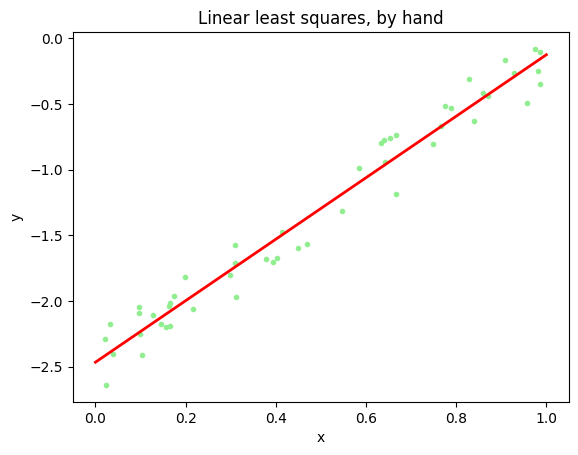

slope : 2.3402003212589406
intercept : -2.465244251353009
r_value : 0.9825309739726255
theta: [np.float64(2.3402003212589406), np.float64(-2.465244251353009)]
LLS from scipy stats time: 0.002234662999999415


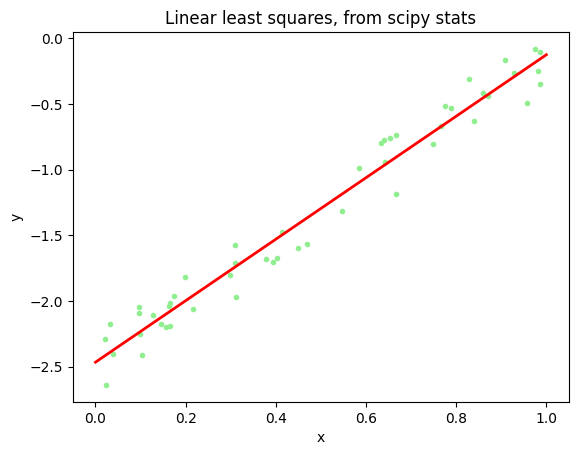

In [83]:
lf = LinearLatentFunction()
size = 50
batch = lf.get_batch(size)
model = LinearModel(size)

start = time.process_time()
x = np.array(batch.x_data)
y = np.array(batch.y_data)
model.train(x, y)
print("theta:", model.theta)
print("LLS time:", time.process_time() - start)
model.plot(x, y, "Linear least squares, by hand")

start = time.process_time()
model.train_from_stats(x, y)
print("theta:", model.theta)
print("LLS from scipy stats time:", time.process_time() - start)
model.plot(x, y, "Linear least squares, from scipy stats")

### Ridge Regression

The ridge regression (or regularized least squares, or Tikhonov regularization) method finds the best linear model from a batch of data, but ensuring that the obtained weights are not too high, using

$$ \boldsymbol{\theta}^* = \min_{\boldsymbol{\theta}} \underbrace{[\frac{\lambda}{2}||\boldsymbol{\theta}||^2 + \frac{1}{2}\|{\bf y}-\boldsymbol{\theta}^\intercal\bar{\bf X}\|^2]}_{L(\boldsymbol{\theta})}.$$

The parameters for the optimal model are given by:

$$ \boldsymbol{\theta}^* = (\lambda \boldsymbol{I} + \bar{\bf X}^\intercal\bar{\bf X})^{-1}{\bar{\bf X}}^\intercal{\bf y}.$$

In the Line class above, fill the `train_regularized(self, x_data, y_data, coef)` function.

And check that it works with a new batch of data

theta regularized: [ 2.73644195 -0.26445294]
regularized LLS : 0.0021754209999897967


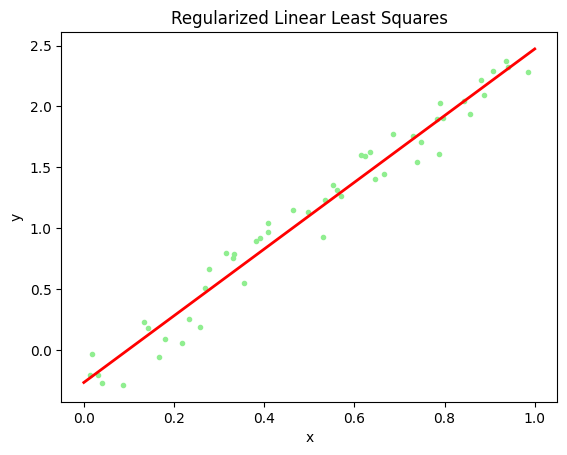

In [217]:
# We use the same batch as before, uncomment if you want to use another batch
# lf = LinearLatentFunction()
# size = 50
# batch = lf.get_batch(size)

model = LinearModel(size)

start = time.process_time()
model.train_regularized(batch.x_data, batch.y_data, coef=0.01)
print("theta regularized:", model.theta)
print("regularized LLS :", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "Regularized Linear Least Squares")

## Study part: linear least squares

### Key study: impact of regularization

For a batch of 50 points, study with the` train_regularized(self,x_data,y_data,coef)` function 
how the residuals degrade as you increase the value of ```coef``` in some well chosen range. 
Explain what you see. A good idea would be to make a picture with coef in the x axis and the residuals in the y axis, 
and then to comment it. Having a look at the learned model may also help.

### Optional study: comparing your LLS code and train_from_stats

Does your ```train(self, x_data, y_data)``` function provide exactly the same results 
as the ```train_from_stats(self, x_data, y_data)``` function?
Call both functions 1000 times with batches containing between 5000 and 50.000 data points and compare their run time with a figure.
Explain what you see.

# Radial Basis Function Networks

## Coding part

Let us now code Radial Basis Function Networks (RBFNs). 
We implement several regression techniques with these models: batch least squares, 
gradient descent, and recursive least squares. 
We first define a general purpose RBFN class that encodes the vector of parameters $\theta$, 
the function $\phi(x)$, a function to compute the error of a model and a plotting function.

Text(0, 0.5, 'Residuals')

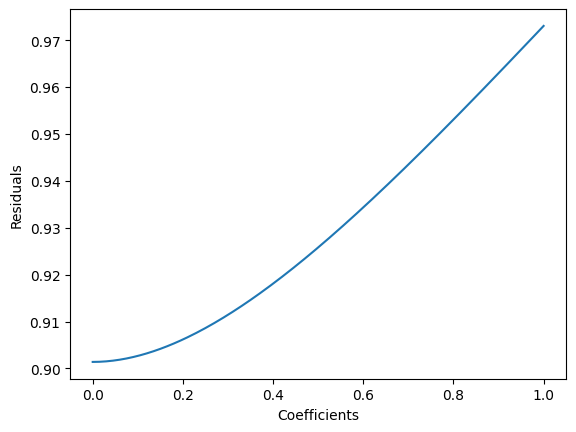

In [219]:
#Key study: impact of regularization
lf = LinearLatentFunction()
size = 50
batch = lf.get_batch(size)
model = LinearModel(size)

coefs=np.arange(0,1.005,0.005)
residuals = []

for coef in coefs:
    model.train_regularized(batch.x_data, batch.y_data, coef)
    residuals.append(model.compute_error(batch.x_data, batch.y_data))

plt.plot(coefs,residuals)
plt.xlabel("Coefficients")
plt.ylabel("Residuals")

In [86]:
color_map = ["yellow","brown","orange","green","cyan","pink","red","blue","black","violet"]

class RBFN(Gaussians):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.theta = np.zeros(self.nb_features)

    def f(self, x):
        """
        Get the output of the function approximator for a given vector of input variables
        :param x: A vector of input variables of size N
        :return: A vector of function approximator outputs with size the number of x datapoints
        """
        f = np.dot(self.phi_output(x).transpose(), self.theta)
        return f

    def feature(self, x, idx):
        """
        Get the output of the idx^th feature for a given input vector
        This is function f() considering only one feature
        Used mainly for plotting the features

        :param x: A vector of dependent variables of size N
        :param idx: index of the feature

        :return: the value of the feature for x
        """
        phi = self.phi_output(x)
        return phi[idx] * self.theta[idx]

    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
        """
        Compute the residuals (squared sum of errors) over all the dataset
        :param x_data: the x values of datapoint
        :param y_data: the y values of datapoint

        :return: the residuals of the data given the model
        """
        error = np.linalg.norm(y_data - self.f(x_data))
        return error

    # ------ Plot function -------#
    def plot(self, x_data, y_data, title):
        """
        Given a dataset x_data, y_data, plots the points of the dataset, 
        the feature functions multiplied by their weight parameter 
        and the resulting model of the latent function
        :param x_data: the x values of datapoint
        :param y_data: the y values of datapoint

        :return: nothing
        """
        size = 500
        xs = np.linspace(0.0, 1.0, size)
        z = []
        for i in xs:
            z.append(self.f(np.array([i])))

        z2 = []
        for i in range(self.nb_features):
            temp = []
            for j in xs:
                temp.append(self.feature(np.array([j]), i))
            z2.append(temp)
            plt.plot(xs, z2[i], color=color_map[i%10])
        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=3, color='red')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
        plt.show()

### Batch RBFNs

When applied to RBFNs, there are two perspectives about the batch least squares method.

#### First perspective

The **first perspective** considers that the RBFN is used to project from an input space into a feature space, 
before performing the standard linear least square calculation in this projected space.

Thus, from the batch of data we build the Gram matrix ${\bf G}$, projecting each datapoint $(x_i)_{1 \leq i \leq N}$ 
into its output vector for all the features $(\phi_j({\bf x}_i))_{1 \leq j \leq E}$. 
Then we apply the standard linear least square method, replacing the augmented design matrix $\bar{\bf X}$ with the Gram matrix ${\bf G}$:

$$  \boldsymbol{\theta}^* = ({\bf G}^\intercal{\bf G})^{-1}{{\bf G}}^\intercal{\bf y}.$$

This is the easiest approach to code in python.

In the code of the ```BatchRBFN1``` class below, fill the ```train_ls(self, x_data, y_data)``` function.

In [123]:
class BatchRBFN1(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    # ------ batch least squares first perspective) ---------
    def train(self, x_data, y_data):
            
        G = self.phi_output(x_data).T
        #print("g", G)
        #print((np.linalg.inv(G.T@G)@G.T).shape)
        #print(y_data.shape)
        self.theta = np.linalg.inv(G.T@G)@G.T@y_data
        #assert False, 'Not implemented yet'


### Second perspective

In the **second perspective**, we perform the whole calculation from scratch. We want to minimize the following error:
$$\epsilon(\boldsymbol{\theta}) = \frac{1}{2N}\sum_{i=1}^N (y_i - f_{\boldsymbol{\theta}}({\bf x}_i))^2.$$

To get a local minimum over $\boldsymbol{\theta}$ of the function $\epsilon(\boldsymbol{\theta})$, 
we need to solve $\nabla_\boldsymbol{\theta} \epsilon(\boldsymbol{\theta}) = {\bf 0}$.
To compute the gradient, we use $\nabla (g^2) = 2g\nabla g$. Therefore, we have

$$\nabla_\boldsymbol{\theta} \epsilon(\boldsymbol{\theta}) = \frac{1}{N}\sum_{i=1}^N  \left(y_i - f_{\boldsymbol{\theta}}\big( {\bf x}_i\big)\right)\nabla_\boldsymbol{\theta} f_{\boldsymbol{\theta}}({\bf x}_i).$$

Since $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, 
we have $\nabla_\boldsymbol{\theta} f_{\boldsymbol{\theta}}({\bf x}_i) = \phi({\bf x}_i)$ and we get

$$\nabla_\boldsymbol{\theta} \epsilon(\boldsymbol{\theta}) = \frac{1}{N}\sum_{i=1}^N  \left(y_i - \phi({\bf x}_i)^\intercal \boldsymbol{\theta}\right)\phi({\bf x}_i)$$

To make the gradient $\nabla_\boldsymbol{\theta} \epsilon(\boldsymbol{\theta}) = {\bf 0}$, we get:

$$\frac{1}{N}\sum_{i=1}^N \left(y_i - \phi({\bf x}_i)^\intercal \boldsymbol{\theta}\right)\phi({\bf x}_i) = 0$$

$$\frac{1}{N}\sum_{i=1}^N \left(\phi({\bf x}_i)y_i - \phi({\bf x}_i) \phi({\bf x}_i)^\intercal \boldsymbol{\theta}\right) = 0$$

$$\left( \sum_{i=1}^N \phi({\bf x}_i) \phi({\bf x}_i)^\intercal \right) \boldsymbol{\theta} = \sum_{i=1}^N \phi({\bf x}_i) y_i.$$

Let us set

$${\bf A} = \left( \sum_{i=1}^N \phi({\bf x}_i) \phi({\bf x}_i)^\intercal \right)$$

and $${\bf b} = \sum_{i=1}^N \phi({\bf x}_i) y_i.$$

We then have ${\bf A} \boldsymbol{\theta} = {\bf b}$.

${\bf A}$ is not necessarily an invertible matrix, and the general solution is obtained as $\boldsymbol{\theta} = A^\sharp b$, 
by using either the ``pseudo-inverse'' $A^\sharp$ ```(np.linalg.pinv(A))``` or using ```theta = np.linalg.solve(A,b)```.

In the ```BatchRBFN2``` class below, fill the code of the ```train(self, x_data, y_data)``` function according to the above perspective.

In [124]:
class BatchRBFN2(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    # ------ batch least squares (second perspective) ---------
    def train(self, x_data, y_data):
        
        
        A = self.phi_output(x_data)@self.phi_output(x_data).T
        #print("A",A)
        #print(A.shape)
        b = self.phi_output(x_data)@y_data
        #print("b", b, b.shape)
        self.theta = np.linalg.pinv(A)@b


Now, run the code below to see if yours works.

theta ls1 : [ 0.65694974  0.476098    0.41842811  0.40798822  0.38818874  0.37731235
  0.32010049  0.01964345 -0.4164016  -0.20956039]
error :  0.20469481366142586
RBFN LS time: 0.002905980000001307


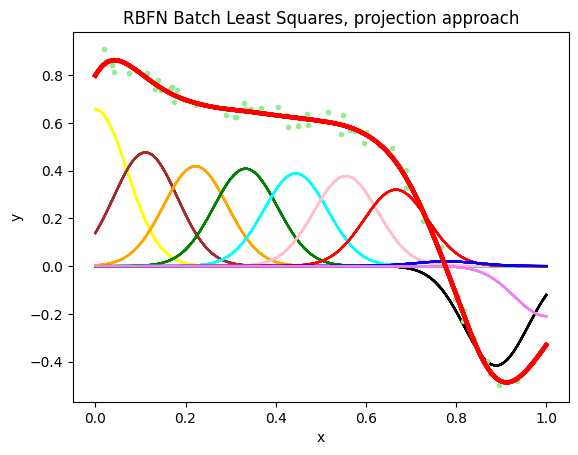

theta ls2 : [ 0.65694974  0.476098    0.41842811  0.40798822  0.38818874  0.37731235
  0.32010049  0.01964345 -0.4164016  -0.20956039]
error :  0.2046948136614258
RBFN LS2 time: 0.0013452179999973168


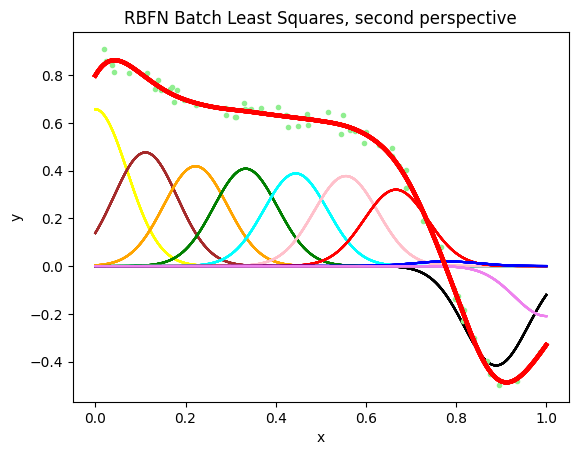

In [129]:
lf = NonLinearLatentFunction()
size = 60
batch = lf.get_batch(size)
model = BatchRBFN1(nb_features=10)

start = time.process_time()
model.train(batch.x_data, batch.y_data)
error = model.compute_error(batch.x_data, batch.y_data)
print("theta ls1 :", model.theta)
print("error : ", error)
print("RBFN LS time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "RBFN Batch Least Squares, projection approach")

model = BatchRBFN2(nb_features=10)
start = time.process_time()
model.train(batch.x_data, batch.y_data)
error = model.compute_error(batch.x_data, batch.y_data)
print("theta ls2 :", model.theta)
print("error : ", error)
print("RBFN LS2 time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "RBFN Batch Least Squares, second perspective")

###  Incremental RBFNs

For this part we define a general purpose IncrRBFN class that we derive below in different subclasses to implement the various algorithms.

In [126]:
class IncrRBFN(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.theta = np.random.random(self.nb_features)
        print(self.theta)

    def f(self, x, theta=None):
        """
        Get the output of the function approximator for a given vector of input variables 
    
        :param x: A vector of dependent variables of size N
        :param theta: A vector of coefficients to apply to the features. 
        :If left blank the method will default to using the trained thetas in self.theta.
        
        :return: A vector of function approximator outputs with size nb_features
        """
        if not hasattr(theta, "__len__"):
            theta = self.theta
        value = np.dot(self.phi_output(x).transpose(), theta)
        return value

    # -------- this function will be redefined in subclasses -----------------
    def train(self, x, y, alpha):
        raise NotImplementedError

#### Gradient Descent

Let the vector $\boldsymbol{\theta}^{(t)}$ be the value of the parameters of the regression model at iteration $t$. 
We observe some new data $({\bf x}^{(t+1)}, y^{(t+1)})$.
The error of the current model on this pair is
$$\epsilon^{(t+1)} = y^{(t+1)} - f_{\boldsymbol{\theta}}( {\bf x}^{(t+1)}).$$

The idea of gradient descent is to slightly modify $\boldsymbol{\theta}$ to decrease $\epsilon^{(t+1)}$.

To do so, we consider the function $\boldsymbol{\theta} \mapsto y^{(t+1)} - f_{\boldsymbol{\theta}}\left( {\bf x}^{(t+1)}\right)$ and compute its gradient in $\boldsymbol{\theta}^{(t+1)}$, which we denote by $\nabla_\boldsymbol{\theta}^{(t+1)}$.

Since we have $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, 
we get $\nabla_\boldsymbol{\theta}^{(t+1)} = - \phi({\bf x}^{(t+1)})$.

The gradient of a function is oriented towards the direction of steepest increase. 
This means that it gives the direction in which a small modification of the vector 
of inputs leads to the largest increase of the function output. 
The opposite direction is the one of steepest decrease.

Here, the goal is to decrease $\epsilon^{(t+1)}$ thus $\boldsymbol{\theta}^{(t+1)}$ should be modified 
in the direction defined by $- \nabla_{\boldsymbol{\theta}}^{(t+1)} =  \phi({\bf x}^{(t+1)})$.
The resulting update formula is

\begin{align*}
 \boldsymbol{\theta}^{(t+1)} &= \boldsymbol{\theta}^{(t)} + \alpha \epsilon^{(t+1)} \nabla_{\boldsymbol{\theta}}^{(t+1)} \\
 &= \boldsymbol{\theta}^{(t)} + \alpha (y^{(t+1)} - f_{\boldsymbol{\theta}}( {\bf x}^{(t+1)})) \phi({\bf x}^{(t+1)})^\intercal \\
\end{align*}

where $\alpha > 0$ is a coefficient called the ``learning rate''.

Using $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, we can also write it:
$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} + \alpha (y^{(t+1)} - \phi({\bf x}^{(t+1)})^\intercal \boldsymbol{\theta}^{(t)}) \phi({\bf x}^{(t+1)})^\intercal.$$

#### Relationship to training neural networks

The approach above is at the heart of machine learning techniques used to tune neural networks. 
The error $\epsilon^{(t+1)}$ is called the **loss function**. 
We have seen that we could slightly decrease this error for next time by descending 
the gradient of this loss with respect to the model parameters $\theta$. 
In neural networks libraries such as pytorch or tensorflow, we do the same: 
we compute a loss corresponding to the error made by the model on some data, 
and the library will perform gradient descent with respect to the parameters by computing the derivative for you.

In the GDRBFN class below, fill the `train(self, x, y, alpha)` function.

In [162]:
class GDRBFN(IncrRBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    # -------- gradient descent -----------------
    def train(self, x, y, alpha):
        phi = self.phi_output(x).flatten()
        #print("phi",phi)
        #print("y", y)
        #print("theta", self.theta)
        y_pred = phi.T @ self.theta
        error = y - y_pred
        self.theta = self.theta + alpha *error * phi
        


In [147]:
u = 4
v = np.array([1,1,1])
print(u-v)

[3 3 3]


And check that it works

[0.50161742 0.51233474 0.26298649 0.12683524 0.45819128 0.52825314
 0.38948719 0.40358375 0.03136998 0.68865367]
error :  0.26139660533786757
RBFN grad descent time: 0.03862299599999375


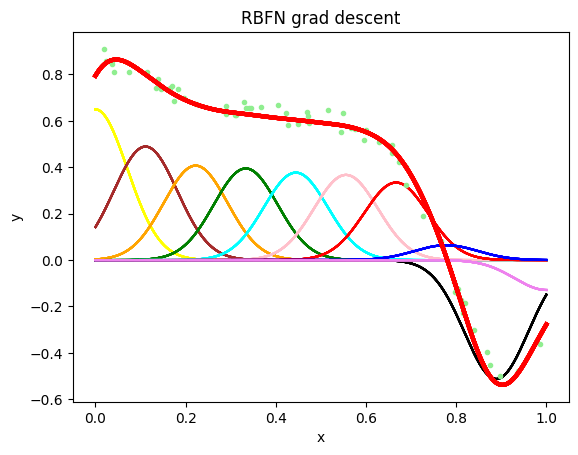

In [163]:
# We use the same batch as before, uncomment if you want to use another batch
# lf = NonLinearLatentFunction()
# size = 500
# batch = lf.get_batch(size)
max_iter = 500
model = GDRBFN(nb_features=10)
start = time.process_time()

for _ in range(max_iter):
    x, y = batch.get_random_sample()
    model.train(x, y, alpha=0.5)

error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN grad descent time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "RBFN grad descent")

#### Recursive Least Squares

Recursive Least Squares is the incremental version of the batch Least Squares method.
In this variant, ${\bf A}$ and ${\bf b}$ are recomputed everytime some new data pair is obtained, with the following equations: 

\begin{align*}
{\bf A}^{(t+1)} &= {\bf A}^{(t)} + \phi({\bf x}^{(t+1)}) \phi({\bf x}^{(t+1)})^\intercal,\\
{\bf b}^{(t+1)} &= {\bf b}^{(t)} + \phi({\bf x}^{(t+1)}) y^{(t+1)}.
\end{align*}

The parameters are then computed as $\boldsymbol{\theta}^{(t+1)} = {\bf A}^{(t+1)\sharp} b^{(t+1)}$.
One may also use ```numpy.linalg.solve(A,b)``` as before, but this can fail when ${\bf A}$ is singular.

Another incremental approach avoids the computation of the pseudo-inverse ${\bf A}^{(t+1)\sharp}$ 
by computing this inverse incrementally, using the Sherman-Morrison formula: 

\begin{align*}
  u = v^T &= \phi({\bf x}^{(t)}) \\
{\bf A}^{(t+1)\sharp} &= {\bf A}^{(t)\sharp} - \frac{{\bf A}^{(t)\sharp} uv {\bf A}^{(t)\sharp}}{1 + v {\bf A}^{(t)\sharp} u},\\
{\bf b}^{(t+1)} &= {\bf b}^{(t)} + \phi({\bf x}^{(t)}).\\
\end{align*}

**Remark:** to apply this formula, we must start with a non-zero value for $A^{(0)\sharp}$, e.g. the Identity matrix.

In the RLSRBFN class below, fill the code of the `train(self, x, y)` function. 
The one with the Sherman-Morrisson approach is provided.

In [176]:
class RLSRBFN(IncrRBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.a = np.zeros(shape=(self.nb_features, self.nb_features))
        self.b = np.zeros(self.nb_features)
        self.a_inv = np.matrix(np.identity(self.nb_features))
    
    # -------- recursive least squares -----------------
    def train(self, x, y):
        phi = self.phi_output(x).reshape(-1, 1)
        self.a = self.a + phi@ phi.T
        self.b = self.b +(phi.flatten() * y)
        self.theta = np.linalg.pinv(self.a)@ self.b

  
    # -------- recursive least squares with Sherman-Morrison -----------------
    def train_rls_sherman_morrison(self, x, y):
        u = self.phi_output(x)
        v = self.phi_output(x).transpose()
        mat = v * self.a_inv * u

        value = mat[0, 0] + 1
        if value == 0: # If it's not invertible
          print("Non invertible matrix")
          return None
        coef = 1.0 / value

        prod = np.dot(u, v)

        tmp_mat = np.dot(self.a_inv, prod) 
        tmp_mat2 = np.dot(tmp_mat, self.a_inv)

        self.a_inv = self.a_inv - coef * tmp_mat2

        tmp_vec = y * verti_to_horiz(self.phi_output(x))
        self.b = self.b + tmp_vec

        # Very surprisingly, we get a [[1 2 3 4]] vec here instead of [1 2 3 4]
        result = np.dot(self.a_inv, self.b)
        # And even more surprisingly we have to write this so that it works
        self.theta = np.array(result)[0]

Finally, run them:

[0.39554349 0.9154204  0.61677897 0.50718061 0.02324184 0.63508672
 0.65796255 0.0306677  0.1722078  0.02084699]
RLS theta [ 0.66050888  0.47537599  0.41937905  0.4066251   0.38950266  0.37584819
  0.3203377   0.01995747 -0.41753711 -0.2082484 ]
error :  0.20483945406892923
RBFN RLS time: 0.2671022890000003


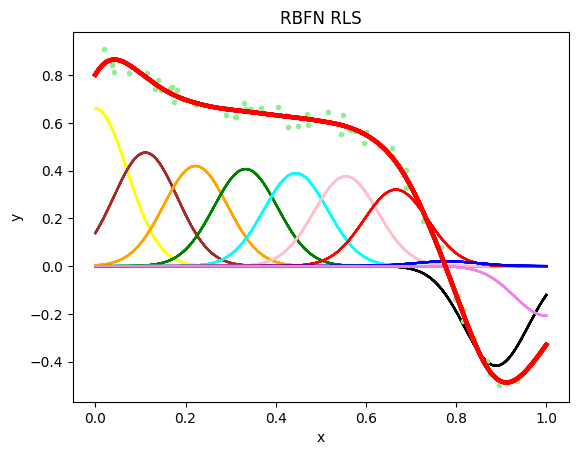

[0.3534683  0.05185604 0.73228733 0.28434656 0.06136486 0.68302765
 0.86777527 0.20670072 0.69446622 0.30973739]
RLS SM theta [ 0.64752565  0.48137149  0.41217372  0.4106945   0.38809862  0.37986661
  0.31927512  0.01787798 -0.41380425 -0.20963845]
error :  0.20542960852641656
RBFN  Sherman-Morrisson time: 0.19871533899999605


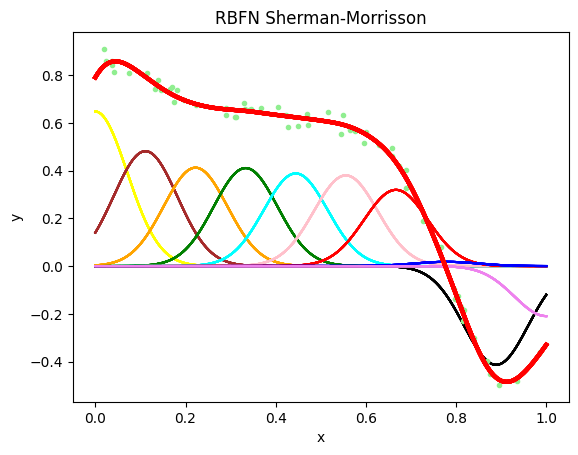

In [177]:
# We use the same batch as before, uncomment if you want to use another batch
# lf = NonLinearLatentFunction()
# size = 500
# batch = lf.get_batch(size)
max_iter = 5000
model = RLSRBFN(nb_features=10)
start = time.process_time()

for _ in range(max_iter):
    x, y = batch.get_random_sample()
    model.train(x, y)

print ("RLS theta", model.theta)
error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN RLS time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "RBFN RLS")

# Need to reinit the model as model.theta must be random again
model = RLSRBFN(nb_features=10)
start = time.process_time()
for _ in range(max_iter):
    x, y = batch.get_random_sample()
    model.train_rls_sherman_morrison(x, y)

print ("RLS SM theta", model.theta)
error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN  Sherman-Morrisson time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "RBFN Sherman-Morrisson")

## Study part: batch RBFNs

 ### Key study: influence of the number of features

Study the evolution of the error as a function of the number of features, from 2 to 60. 
A good idea would be to make a picture with the number of features in the x axis and the residuals in the y axis, 
and then to comment it. Have a look at the model when the number of features is large (e.g. 60). What is happening?

### Optional study: comparing both perspectives

Calling the train functions at least 1000 times, comment on the difference in computation time between the first and the second perspective.

## Study part: incremental RBFNs

### Key study: Incremental versus Batch

By comparing their computation time and error with a growing number of features, 
comment on the main differences between incremental and batch methods with RBFNs. 
What are their main advantages and disadvantages? 
Explain how you would choose between an incremental and a batch method, depending on the context.

### Optional study 1: comparing recursive variants

By varying the number of features, the number of samples and the amount of noise in the data generator, 
compare the different incremental variants (gradient descent and RLS with and without the Sherman-Morrison formula). 
Which is the most precise? The fastest? Using graphical displays where you are varying the above parameters is strongly encouraged. 
To change the amount of noise in the generated data, 
look in the [latent_function.py](https://github.com/osigaud/regressionLabs/blob/main/regression_labs/latent_function.py) file.

### Optional study 2: Studying overfitting

From the same dataset, generate two batches, a training batch on which your model is trained
and a validation batch which is used to determine when incremental regression starts overfitting
Plot training and validation error curves, and conclude on the right number of iterations to avoid overfitting

Text(0, 0.5, 'Residuals')

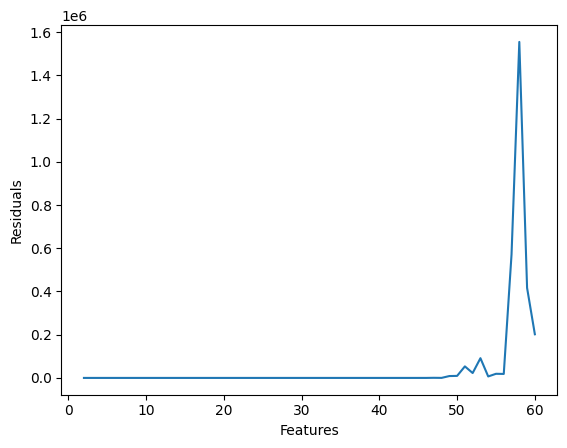

In [ ]:
#Key study : influence of the number of features
lf = NonLinearLatentFunction()
size = 60
batch = lf.get_batch(size)
residuals = []
features  = []
for i in range(2,61):
    model = BatchRBFN1(nb_features=i)
    features.append(i)
    model.train(batch.x_data, batch.y_data)
    residuals.append(model.compute_error(batch.x_data, batch.y_data))
plt.plot(features,residuals)
plt.xlabel("Features")
plt.ylabel("Residuals")


Text(0, 0.5, 'Residuals')

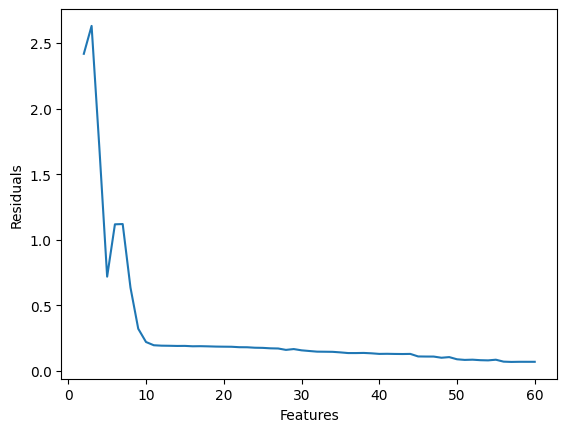

In [228]:
#Key study : influence of the number of features (BatchRBFN2)
lf = NonLinearLatentFunction()
size = 60
batch = lf.get_batch(size)
residuals = []
features  = []
for i in range(2,61):
    model = BatchRBFN2(nb_features=i)
    features.append(i)
    model.train(batch.x_data, batch.y_data)
    residuals.append(model.compute_error(batch.x_data, batch.y_data))
plt.plot(features,residuals)
plt.xlabel("Features")
plt.ylabel("Residuals")

[0.53096905 0.04719869]
[0.64513584 0.14935443 0.4764568 ]
[0.0559511  0.8388628  0.58416673 0.13253591]
[0.94018601 0.00982457 0.29103785 0.94471688 0.60628814]
[0.66569193 0.88973327 0.74066393 0.31053113 0.97582555 0.82057538]
[0.3221139  0.03772286 0.99846927 0.47781821 0.81957256 0.16696085
 0.10230784]
[0.00675538 0.17983122 0.29186438 0.4854401  0.09414686 0.22624603
 0.50665571 0.50971527]
[0.13729946 0.11594107 0.6610769  0.60976768 0.71458696 0.0826617
 0.06950113 0.04791014 0.68684127]
[0.86416851 0.2948722  0.40473593 0.26755018 0.49095969 0.48995361
 0.7489659  0.04599792 0.35210713 0.75819276]
[0.8550841  0.45760918 0.03787238 0.21452796 0.09688895 0.2506935
 0.76807113 0.85126889 0.7654084  0.66955952 0.68210913]
[0.96061401 0.48194689 0.65447632 0.10670418 0.99236667 0.79596275
 0.5602788  0.40673345 0.94928905 0.06750816 0.03215589 0.49781451]
[0.03379904 0.62500171 0.1738793  0.62917592 0.86426556 0.66936692
 0.48718052 0.88988591 0.40199152 0.37797347 0.96066746 0.57

Text(0, 0.5, 'Residuals')

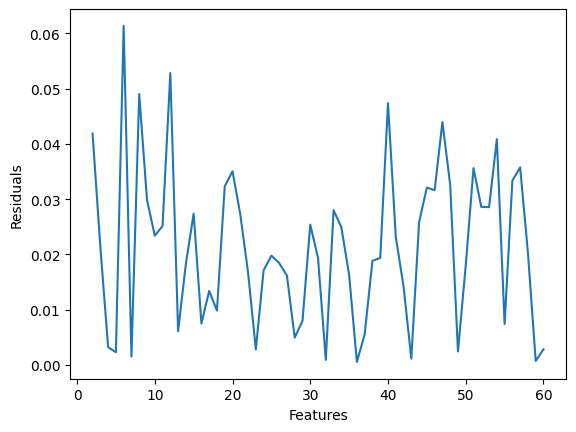

In [230]:
#Key part : Incremental vs Batch 
lf = NonLinearLatentFunction()
size = 60
batch = lf.get_batch(size)
max_iter = 5000
residuals = []
features  = []

for i in range(2, 61):
    model = RLSRBFN(nb_features=i)
    features.append(i)
    for _ in range(max_iter):
        x, y = batch.get_random_sample()
        model.train_rls_sherman_morrison(x, y)
        errors = []
        errors.append(model.compute_error(x, y))
    residuals.append(np.mean(errors))

plt.plot(features, residuals)
plt.xlabel("Features")
plt.ylabel("Residuals")

In [ ]:
# To be completed...

assert False, 'Not implemented yet'


In [ ]:
# To be completed...

assert False, 'Not implemented yet'


# Locally Weighted Regression

Another family of models is Locally Weighted Least Squares (LWLS).
The LWLS algorithm uses a weighted sum of $M$ local linear models.
For each local model $\boldsymbol{\theta}_k$, the size of the vector $\boldsymbol{\theta}_k$ 
is the number of dimensions of $\bar{\bf x}$ to take the intercept 
into account (remember that $\bar{\bf x} = ( x_1 \ x_2 \cdots x_d \ 1)^\intercal$ as defined in the provided code 
with the ```bar(x)``` function.
Thus $\dim (\boldsymbol{\theta}_k) = \dim ({\bf x}) +1 = d + 1$.

The model of the global latent function can be written

$$f({\bf x}) = \sum_{k=1}^{M}  \frac{\phi_k({\bf x}). m_{\boldsymbol{\theta}_k}({\bf x})}{\sum_{j=1}^{M} \phi_j({\bf x})},$$

with $m_{\boldsymbol{\theta}_k}({\bf x}) = \bar{\bf x}^\intercal \boldsymbol{\theta}_k $ and where $M$ is the number of models.

Each local model $\boldsymbol{\theta}_k$ is optimized by minimizing the following locally weighted error from $N$ datapoints:

$$\epsilon_k(\boldsymbol{\theta}_k) = \frac{1}{2N}\sum_{i=1}^N \phi_k({\bf x}_i)\left(y_i - m_{\boldsymbol{\theta}_k}({\bf x}_i)\right)^2$$

$$= \frac{1}{2N}\sum_{i=1}^N \phi_k( {\bf x}_i) \left(y_i- (\bar{\bf x}_i)^\intercal .\boldsymbol{\theta}_{i} \right)^2.$$

As with the least squares method, we try to cancel out the gradient, which amounts to solving:

$$-\frac{1}{N}\sum_{i=1}^N \phi_k({\bf x}_i)\bar{\bf x}_i \left(y_i - (\bar{\bf x}_i)^\intercal .\boldsymbol{\theta}_k \right) = 0.$$

Therefore, we pose $\boldsymbol{\theta}_k = {\bf A}^\sharp_k {\bf b}_k$, with: 
$${\bf A}_k = \sum_{i=1}^N \phi_k({\bf x}_i). \bar{\bf x}_i^\intercal. (\bar{\bf x}_i)$$
$${\bf b}_k = \sum_{i=1}^N \phi_k({\bf x}_i). \bar{\bf x}_i^\intercal. y_i.$$

This calculation gives us the parameters $\boldsymbol{\theta}_k$ of each local linear model. 
The global parameter $\boldsymbol{\theta}$ is now a matrix resulting from the concatenation of all local models $\boldsymbol{\theta}_k$.

## Coding part

The code corresponding to the LWR method is available in the ```LWR``` class below. 

**In this code, you have to fill the ```train(self, x_data, y_data)``` function**

In [195]:
class LWR(Gaussians):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        # The first dimension is 2 because we assume the input is one-dimensional
        # So we just have two parameters per receptive field
        self.theta = np.zeros((2, self.nb_features))

    def f(self, x):
        """
        Get the output of the function approximator for a given vector of datapoints
        :param x: a single vector of N datapoints (each datapoint being of dimension d=1)
        :returns: a vector of N function approximator outputs
        """
        wval = bar_design(x)
        phi = self.phi_output(x)
        linear_model = np.dot(wval, self.theta)
        val = np.dot(linear_model, phi)
        numerator = np.sum(val, axis=1)
        return numerator / np.sum(phi, axis=0)

    def feature(self, x, idx):
        """
         Get the output of the idx^th feature for a given input variable(s)
         :param x: a single or vector of dependent variables with size [d] for which to calculate the features
         :param idx: index of the feature
         :returns: a vector of values
         """
        return np.dot(bar_design(x), self.theta[:, idx])

    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
      return np.linalg.norm(y_data - self.f(x_data))

    # ----------------------#
    # # Training Algorithm ##
    # ----------------------#

    def train(self, x_data, y_data) -> None:
        """
        Locally weighted least square function
        This code is specific to the 1D case
        :param x_data: a vector of x values
        :param y_data: a vector of y values
        :return: nothing (set the self.theta vector)
        """
        for k in range(self.nb_features):
            A = np.zeros((2, 2))
            b = np.zeros((2, 1))

            nb_points = x_data.shape[0]
            for i in range(nb_points):

                x_i = x_data[i].reshape(1, x_data.shape[1])
                y_i = y_data[i]

                phi = self.phi_output(x_i)
                print("x_i",x_i)
                print("y_i",y_i)
                print("phi", phi)
                x_bar = np.vstack((x_i.T, np.ones((1,1))))
                phi_k = phi[k]
                A += phi_k *x_bar * x_bar.T
                b += phi_k *x_bar * y_i


            result = np.dot(np.linalg.pinv(A), b)
            for i in range(2):
                self.theta[i, k] = result[i, 0]


    def plot(self, x_data, y_data, title):
        xs = np.linspace(0.0, 1.0, 1000)
        z = []
        for i in xs:
            val = self.f(np.array([[i]]))
            z.append(val)


        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=2, color='red')
        for i in range(self.nb_features):
            ww = (1.0 - 0.0) / self.nb_features / 2.
            xstmp = np.linspace(self.centers[i] - ww, self.centers[i] + ww, 100)

            z2 = []
            for j in xstmp:
                z2.append(self.feature(np.array([[j]]), i))
            plt.plot(xstmp, z2, lw=2, color='blue', ls='-')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
        plt.show()

Once this is done, you can run the code:

x_i [[0.91401306]]
y_i -0.34273792067154135
phi [[5.22607562e-37]
 [1.00725447e-28]
 [1.64350361e-21]
 [2.27023110e-15]
 [2.65483430e-10]
 [2.62828658e-06]
 [2.20280453e-03]
 [1.56295744e-01]
 [9.38828546e-01]
 [4.77412040e-01]]
x_i [[0.47973797]]
y_i 0.7715897881318804
phi [[1.01105920e-10]
 [1.25474718e-06]
 [1.31826833e-03]
 [1.17251755e-01]
 [8.82882349e-01]
 [5.62800224e-01]
 [3.03720170e-02]
 [1.38758934e-04]
 [5.36680997e-08]
 [1.75727378e-12]]
x_i [[0.85896739]]
y_i -0.5607430945404612
phi [[9.05040792e-33]
 [5.13318065e-25]
 [2.46475007e-18]
 [1.00190645e-12]
 [3.44785828e-08]
 [1.00447604e-04]
 [2.47740898e-02]
 [5.17277725e-01]
 [9.14361208e-01]
 [1.36829504e-01]]
x_i [[0.58929709]]
y_i 0.8089581886262923
phi [[8.28341520e-16]
 [1.17312109e-10]
 [1.40651446e-06]
 [1.42762291e-03]
 [1.22673501e-01]
 [8.92392589e-01]
 [5.49577694e-01]
 [2.86530057e-02]
 [1.26467584e-04]
 [4.72559176e-08]]
x_i [[0.42269958]]
y_i 0.6529746796236695
phi [[1.73878632e-08]
 [6.07503740e-05]
 [1.796

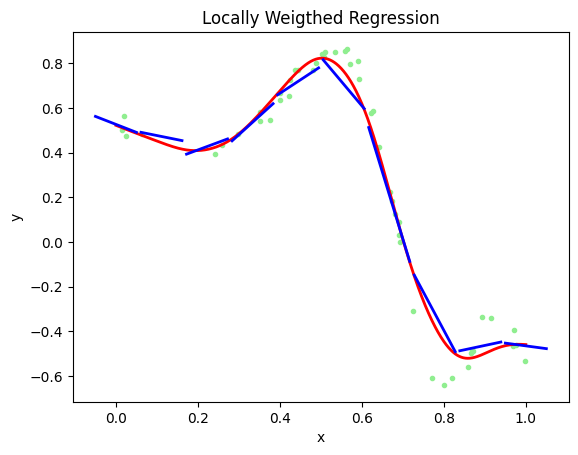

In [196]:
lf = NonLinearLatentFunction()
size = 50
batch = lf.get_batch(size)
model = LWR(nb_features=10)

start = time.process_time()
model.train(batch.x_data, batch.y_data)
print("LWR time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data, "Locally Weigthed Regression")

## Study part: LWR

### Key study: impact of the number of features

Study the impact of the number of features on the accuracy of LWR: make a drawing where you measure 
the residuals as a function of the number of features.

### Optional study: regions with missing data

Introduce a filter that removes part of the data in some region of the x axis. Study how LWR behaves in regions where data is sparse.
the residuals as a function of the number of features.

# Regression with Neural Networks (in pytorch)

In this part we perform regression with neural networks.
We are using pytorch, which does for you a lot of what you have to code when using gradient descent with RBFNs.

All the code for performing regression is provided, you can focus on the study part.
The study below will focus on different training regimes.

In [199]:
!pip install torch

import torch as th
from torch import nn
from torch.nn import functional as func
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

  Using cached torch-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.10.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached cuda_bindings-12.9.4-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_6

ModuleNotFoundError: No module named 'torch'

We use pytorch Dataset and DataLoader classes to facilitate data processing

In [ ]:
class NonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, x_data, y_data):
        self.x_data = th.from_numpy(x_data).float()
        self.y_data = th.from_numpy(y_data).float()

    def __len__(self):
        return(len(self.x_data))

    def __getitem__(self, idx):
        return(self.x_data[idx], self.y_data[idx])

Now, we define a neural network model.
It has the same $f()$ function as previous models, and the ```compute_error(x,y)``` function is also the same.
But now, the training function just calls ```update(loss)``` and gradient descent is performed using pytorch functions.

In [ ]:
##################################################
## set up a multi-layer perceptron with PyTorch
##################################################

class NeuralNetwork(nn.Module):

  def __init__(self, l1, l2, l3, l4, out, learning_rate):
    super(NeuralNetwork, self).__init__()
    self.sigmoid = nn.Sigmoid() # not used in the default version
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(l1, l2)
    self.fc2 = nn.Linear(l2, l3)
    self.fc3 = nn.Linear(l3, l4)
    self.fc4 = nn.Linear(l4, out)
    self.optimizer = th.optim.Adam(self.parameters(), lr=learning_rate) # Here we could use different optimizers

  def forward(self, x):
      # x is assumed to be a tensor
      hidden1 = self.relu(self.fc1(x))
      hidden2 = self.relu(self.fc2(hidden1))
      hidden3 = self.relu(self.fc3(hidden2))
      output = self.fc4(hidden3)
      return output
  
  def compute_error(self, x_data, y_data):
    """
    Compute the residual error
    :param x_data: the x values of datapoint
    :param y_data: the y values of datapoint
    :return: the total residual error
    """
    x = (th.from_numpy(x_data).float())
    return np.linalg.norm(y_data - self.forward(x).detach().squeeze().numpy())

  def update(self, loss, retain_graph=False) -> None:
    """
    Apply a loss to a network using gradient backpropagation
    :param loss: the applied loss
    :return: nothing
    """
    self.optimizer.zero_grad()
    loss.backward(retain_graph=retain_graph)
    self.optimizer.step()

  def plot(self, x_data, y_data, title):
    """
    Given a dataset x_data, y_data, plots the points of the dataset (in green), 
    and the resulting model of the latent function (in red)
    :param x_data: the x values of datapoint
    :param y_data: the y values of datapoint
    :param title: a title for the figure
    :return: nothing
    """
    
    plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
      
    inputs = th.from_numpy(x_data).float()
    formatted_input = th.reshape(inputs, (len(inputs), 1))
    y_model = model.forward(formatted_input).detach().squeeze().numpy()
      
    plt.plot(x_data, y_model, 'o', markersize=4, color='red')

    size = 500
    xs = np.linspace(0.0, 1.0, size)
    txs = th.from_numpy(xs).float()
    ftxs = th.reshape(txs, (len(txs), 1))
    ys = model.forward(ftxs).detach().squeeze().numpy()
    plt.plot(xs, ys, lw=1, color='pink')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

### General data set-up

We store data into a pytorch dataset

In [ ]:
# We use a non-linear batch of size 100
lf = NonLinearLatentFunction()
size = 100
batch = lf.get_batch(size)

# instantiate Dataset object for current training data
train_data = NonLinearRegressionData(batch.x_data, batch.y_data)

### Training loop

In [ ]:
def train(max_iter, freq):
  current_loss = 0.0

  # Iterate for a number of training iterations
  for epoch in range(max_iter):
    # Iterate over the DataLoader for training data
    for _, data in enumerate(train_dataloader, 0):
      # Get inputs
      inputs, targets = data
      formatted_input = th.reshape(inputs, (len(inputs), 1))
      outputs = model(formatted_input).squeeze()
      # Compute loss
      loss = func.mse_loss(outputs, targets)
      # Perform optimization
      model.update(loss)
      # Print statistics
      current_loss += loss.item()

    if (epoch + 1) % freq == 0:
      print('Loss after iteration %5d: %.3f' %
            (epoch + 1, current_loss))
      current_loss = 0.0

### Batch, iterative version

We first train the network with a single batch of data.
We perform max_iter iterations to improve the network.

In [ ]:
# Instantiate DataLoader
# We get a full size batch and shuffle the data
train_dataloader = DataLoader(train_data, batch_size=size, shuffle=True)

model = NeuralNetwork(1, 10, 10, 10, 1, learning_rate=3e-3)

max_iter = 5000
print("nb iterations", max_iter)

start = time.process_time()
train(max_iter, 250)

print("Batch training time:", time.process_time() - start)
error = model.compute_error(batch.x_data, batch.y_data)
print("Global batch error:", error)
model.plot(batch.x_data, batch.y_data, "Batch version")

### Incremental version using minibatches

For getting minibatches, see the [get_minibatch()](https://github.com/osigaud/regressionLabs/blob/main/regression_labs/batch.py) function.

In [ ]:
# Instantiate DataLoader
# We get mini_batches of size 25 and shuffle the data
train_dataloader = DataLoader(train_data, batch_size=25, shuffle=True)
model = NeuralNetwork(1, 10, 10, 10, 1, learning_rate=1e-3)

max_iter = 5000
print("nb iterations", max_iter)

start = time.process_time()
train(max_iter, 250)
print("Incremental mini-batch training time:", time.process_time() - start)
error = model.compute_error(batch.x_data, batch.y_data)
print("Global batch error:", error)
model.plot(batch.x_data, batch.y_data, "Incremental mini-batch version")

You can see that the batch version is a special case of the mini-batch version
where the size of the mini-batch is the size of the batch.

## Study part: neural networks

### Key study: comparisons between versions

Play with the dataset size. Once you have properly tuned the variants, study the evolution of the final error
and the training time depending on the size of the minibatch for a given budget of iterations.

In [ ]:
# This key study is expected for the lab

# To be completed...

assert False, 'Not implemented yet'


### Optional study 1: preventing overfitting

Distinguish training, validation and test batches, train the network until the validation loss stops decreasing, 
count the number of training epochs and measure the loss on the test batch.
By running a number of training epochs smaller and larger than the one found with the validation loss approach, 
study if this approach truly prevents overfitting. Showing the training loss and validation loss curves is higly recommended.

### Optional study 2: impact of the network architecture

Vary the activation functions, the number of layers and the number of neurons per layer and study the impact on regression error.

# Global study part: comparing the families of methods

### Optional study 1: Batch RBFNs versus LWR

By using the same batches of data and tuning your models depending on these batches, compare the performance
and training time of batch RBFNs and LWR under various training regimes. Change the amount of noise, the quantity of data,
or study the impact of missing data.

### Optional study 2: Incremental RBFNs versus neural networks

By using the same batches of data and tuning your models depending on these batches, compare the performance
and training time of incremental RBFNs and neural networks under various training regimes.
 Change the amount of noise, the quantity of data, or study the impact of missing data.